# Clips and Frames in Videos

**Videos can get pretty large but sometimes the interesting aspects are in [portions of the video](https://docs.aperturedata.io/category/video-and-related-commands), called Clip in ApertureDB, or individual frames, called Frame**

## Connect to the database

If you haven't already setup the database or configured it, check out our [quick start guide](https://docs.aperturedata.io/Setup/QuickStart)

In [ ]:
# Install the required client packages if needed
%pip install --upgrade --quiet pip
%pip install --upgrade --quiet aperturedb

In [1]:
from aperturedb.CommonLibrary import create_connector

# Create the connector for ApertureDB
client = create_connector()

In [2]:
# Simple query to see how the database is doing
# https://docs.aperturedata.io/query_language/Reference/db_commands/GetStatus
query = [{
    "GetStatus": {
    }
}]

# Execute the query to get back a JSON response for GetStatus 
response, blobs = client.query(query)

client.print_last_response()

[
    {
        "GetStatus": {
            "info": "OK",
            "status": 0,
            "system": "ApertureDB",
            "version": "0.17.23"
        }
    }
]


## Add a Video and Interesting Clip + Frame in it to ApertureDB

**For bulk additions, we recommend using the [Python SDK loaders](http://docs.aperturedata.io/category/manage-multimodal-datasets)**

In [ ]:
# Download the sample file
! mkdir -p data; cd data; wget https://github.com/aperture-data/Cookbook/blob/e333f6c59070b9165033d9ddd5af852a6b9624ba/notebooks/simple/data/crepe_flambe.mp4; cd -

In [3]:
query = [{
    "AddVideo": {
        "_ref": 1,                         # Assign a reference to the result of this query which is this video we are adding
        "properties": {
            "name": "crepe_flambe",
            "id": 45,
            "category": "dessert",
            "cuisine": "French",
            "location": "Brittany",
            "caption": "Special Brittany flambe crepe"
        },
        "if_not_found": {                  # avoid adding twice
            "id": ["==", 45]
        }
    }
}, {
    "AddClip": {                           # In this case add a clip based on frame number but there are other options like time fraction
        "video_ref": 1,
        "frame_number_range": {
            "start": 10,
            "stop": 150
        },
        "properties": {
            "label": "active flames"
        }
    }
},{
    "AddFrame": {                          # introduce a key frame you care about. You could also try ExtractFrame to get something on the fly
        "video_ref": 1,
        "frame_number": 65,
        "properties": {
            "scene": "tallest flame"
        }
    }
}]

# Read the image data as a binary blob
fd = open("data/crepe_flambe.mp4", 'rb')
array = [ fd.read() ]
fd.close()

response, blobs = client.query(query, array)

client.print_last_response()

[
    {
        "AddVideo": {
            "status": 0
        }
    },
    {
        "AddClip": {
            "status": 0
        }
    },
    {
        "AddFrame": {
            "status": 0
        }
    }
]


We can see that the clip was correctly added. 
Note that a Clip in ApertureDB stores only the position of the clip
within the video as metadata properties. There is only one copy of the video in ApertureDB.

Same goes for Frame as well.

## Retrieve the Interesting Cooking Moments

In [4]:
query = [{
    "FindClip": {
        "blobs": True,
        "constraints": {
            "label": ["==", "active flames"]
        },
        "fast_cut": True,                        # Optimized retrieval of clip 
        "results": {
            "all_properties": True
        },
        "operations": [
            {
                "type": "resize",
                "width": 320,
                "height": 240
            }
        ]
    }
},{
    "FindFrame": { 
        "blobs": True,
        "constraints": {
            "scene": ["==", "tallest flame"]
        },
        "results": {
            "all_properties": True
        }
    }
}]

response, blobs = client.query(query)

client.print_last_response()

[
    {
        "FindClip": {
            "blobs_start": 0,
            "entities": [
                {
                    "_frame_number_range": {
                        "start": 10,
                        "stop": 150
                    },
                    "_range_start": 10,
                    "_range_stop": 150,
                    "_range_type": 1,
                    "_uniqueid": "6.3.224060",
                    "label": "active flames"
                }
            ],
            "returned": 1,
            "status": 0
        }
    },
    {
        "FindFrame": {
            "blobs_start": 1,
            "entities": [
                {
                    "_blob_index": 1,
                    "_frame_number": 65,
                    "_label": "None",
                    "_uniqueid": "24.0.224060",
                    "scene": "tallest flame"
                }
            ],
            "returned": 1,
            "status": 0
        }
    }
]


### ApertureDB extracts the clip and frame from the original video on the fly.

In [5]:
from aperturedb import NotebookHelpers as nh

nh.display_video_mp4(blobs[0])

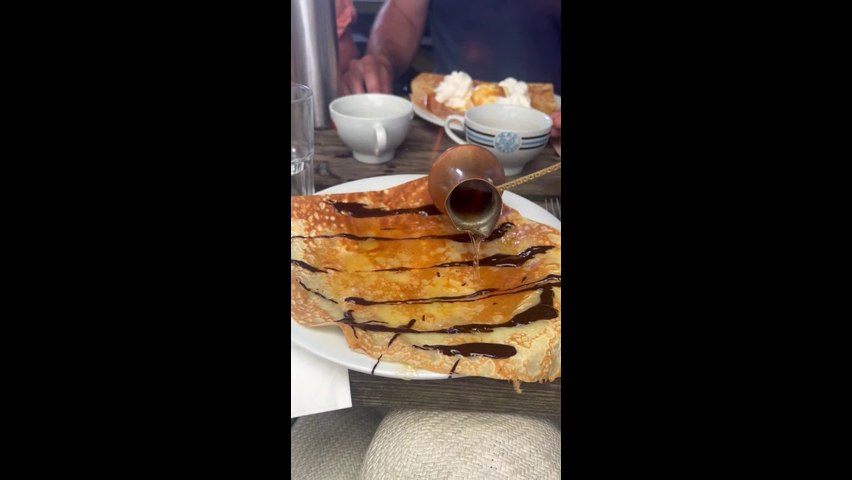

In [6]:
from IPython.display import display,Image
image = Image(blobs[1], format="JPEG")
display(image)

### With Transformations

In [7]:
query = [{
    "FindClip": {
        "blobs": True,
        "constraints": {
            "label": ["==", "active flames"]
        },
        "fast_cut": True,
        "operations": [
            {
                "type": "resize",
                "width": 320,
                "height": 240
            }
        ],
        "results": {
            "all_properties": True
        }
    }
}]

response, blobs = client.query(query)

client.print_last_response()

nh.display_video_mp4(blobs[0])

[
    {
        "FindClip": {
            "blobs_start": 0,
            "entities": [
                {
                    "_frame_number_range": {
                        "start": 10,
                        "stop": 150
                    },
                    "_range_start": 10,
                    "_range_stop": 150,
                    "_range_type": 1,
                    "_uniqueid": "6.3.224060",
                    "label": "active flames"
                }
            ],
            "returned": 1,
            "status": 0
        }
    }
]


## Cleanup

In [8]:
query = [ {
    "DeleteFrame": {
        "constraints": {
            "scene": ["==", "tallest flame"]
        }
    }
},{
    "DeleteClip": {
        "constraints": {
            "label": ["==", "active flames"]
        }
    }
},{
    "DeleteVideo": {
        "constraints": {
            "name": ["==", "crepe_flambe"]
        }
    }
}]

res, blobs = client.query(query)

client.print_last_response()

[
    {
        "DeleteFrame": {
            "count": 1,
            "status": 0
        }
    },
    {
        "DeleteClip": {
            "count": 1,
            "status": 0
        }
    },
    {
        "DeleteVideo": {
            "count": 1,
            "status": 0
        }
    }
]


## What's next?

* [Bulk load](https://docs.aperturedata.io/HowToGuides/Ingestion/Ingestion/Ingestion) clips or frames
* Add [text](https://docs.aperturedata.io/HowToGuides/start/Blobs) or [images](https://docs.aperturedata.io/HowToGuides/start/Images) to ApertureDB